In [27]:
import numpy as np
from numpy import cos, sin
import matplotlib.pyplot as plt
from qiskit.quantum_info import (
    Statevector,
    state_fidelity,
    Operator,
    average_gate_fidelity
)
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import RXGate, CXGate

i = 1j

In [39]:
def cycle_circuit(ϕ, γ):
    qc = QuantumCircuit(2)
    qc.append(RXGate(ϕ), [0])
    qc.append(RXGate(γ * ϕ), [1])
    qc.append(CXGate(), [0, 1])
    return qc


def ideal_cycle(ϕ):
    qc = QuantumCircuit(2)
    qc.append(RXGate(ϕ), [0])
    qc.append(CXGate(), [0, 1])
    return qc


def full_circuit(ϕ, γ, n, initial_state=Statevector.from_int(0, dims=(2, 2))):
    qc = QuantumCircuit(2)
    qc.prepare_state(initial_state)
    for _ in range(n):
        qc.compose(cycle_circuit(ϕ, γ), inplace=True)
    return qc


def ideal_full_circuit(ϕ, n, initial_state=Statevector.from_int(0, dims=(2, 2))):
    qc = QuantumCircuit(2)
    qc.prepare_state(initial_state)
    for _ in range(n):
        qc.compose(ideal_cycle(ϕ), inplace=True)
    return qc

def inverse_unitary(qc:QuantumCircuit):
    return Operator(qc.inverse())

In [40]:
def alpha_prime(α, β, τ, δ, ϕ, γ):
    return (
        α * cos(ϕ / 2) * cos(γ * ϕ / 2)
        - i * β * cos(ϕ / 2) * sin(γ * ϕ / 2)
        - i * τ * sin(ϕ / 2) * cos(γ * ϕ / 2)
        - δ * sin(ϕ / 2) * sin(γ * ϕ / 2)
    )


def beta_prime(α, β, τ, δ, ϕ, γ):
    return (
        -i * α * sin(γ * ϕ / 2) * cos(ϕ / 2)
        + β * cos(γ * ϕ / 2) * cos(ϕ / 2)
        - τ * sin(γ * ϕ / 2) * sin(ϕ / 2)
        - i * δ * cos(γ * ϕ / 2) * sin(ϕ / 2)
    )


def tau_prime(α, β, τ, δ, ϕ, γ):
    return (
        -α * sin(ϕ / 2) * sin(γ * ϕ / 2)
        - i * β * sin(ϕ / 2) * cos(γ * ϕ / 2)
        - i * τ * sin(γ * ϕ / 2) * cos(ϕ / 2)
        + δ * cos(ϕ / 2) * cos(γ * ϕ / 2)
    )


def delta_prime(α, β, τ, δ, ϕ, γ):
    return (
        -i * α * sin(ϕ / 2) * cos(γ * ϕ / 2)
        - β * sin(ϕ / 2) * sin(γ * ϕ / 2)
        + τ * cos(ϕ / 2) * cos(γ * ϕ / 2)
        - i * δ * sin(γ * ϕ / 2) * cos(ϕ / 2)
    )


def new_state(α, β, τ, δ, ϕ, γ):
    return (
        alpha_prime(α, β, τ, δ, ϕ, γ),
        beta_prime(α, β, τ, δ, ϕ, γ),
        tau_prime(α, β, τ, δ, ϕ, γ),
        delta_prime(α, β, τ, δ, ϕ, γ),
    )


def analytic_spillover(α, β, τ, δ, ϕ, γ, n):
    for _ in range(n):
        α, β, τ, δ = new_state(α, β, τ, δ, ϕ, γ)

    final_state = Statevector([α, β, τ, δ], dims=(2, 2)).reverse_qargs()
    assert (
        final_state.is_valid()
    ), f"Final state is not valid: norm {np.linalg.norm(final_state.data)}"
    return Statevector([α, β, τ, δ], dims=(2, 2)).reverse_qargs()


def symbolic_spillover(α, β, τ, δ, ϕ, γ, n):
    for _ in range(n):
        α, β, τ, δ = new_state(α, β, τ, δ, ϕ, γ)

    return α, β, τ, δ

In [41]:
# Define the number of cycles
n = 4

# Define the cycle circuit parameters
ϕ = np.pi / 2
γ = 0.1

# Define the initial state
α = 1.0
β = 0.0
τ = 0.0
δ = 0.0

statevector = Statevector([α, β, τ, δ], dims=(2, 2))
assert statevector.is_valid()
print(statevector)

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


In [42]:
from qiskit.circuit import Parameter

α_p = Parameter("α")
β_p = Parameter("β")
τ_p = Parameter("τ")
δ_p = Parameter("δ")
ϕ_p = Parameter("ϕ")
γ_p = Parameter("γ")

α_new, β_new, τ_new, δ_new = symbolic_spillover(α_p, β_p, τ_p, δ_p, ϕ_p, γ_p, n)

In [43]:
from sympy import latex, sympify

print(
    α_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ}).sympify().simplify()
)
print(
    β_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ}).sympify().simplify()
)
print(
    τ_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ}).sympify().simplify()
)
print(
    δ_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ}).sympify().simplify()
)

-0.5 + 1.0*sin((1/2)*ϕ)**4*sin((1/2)*γ*ϕ)**4 + 1.0*sin((1/2)*ϕ)**4*cos((1/2)*γ*ϕ)**4 + 0.375*cos(ϕ)**2*cos(2*γ*ϕ) + 0.125*cos(2*ϕ)*cos(γ*ϕ)**2 + 1.0*cos((1/2)*ϕ)**4*sin((1/2)*γ*ϕ)**4 + 1.0*cos((1/2)*ϕ)**4*cos((1/2)*γ*ϕ)**4 + (0.0 + 16.0*I)*sin((1/2)*ϕ)**2*cos((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)*cos((1/2)*γ*ϕ)**3 + 12.0*sin((1/2)*ϕ)**2*cos((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)**2*cos((1/2)*γ*ϕ)**2 + (-0.0 - 16.0*I)*sin((1/2)*ϕ)**2*cos((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)**3*cos((1/2)*γ*ϕ) - 0.375*cos(ϕ)**2 - 0.125*cos(γ*ϕ)**2 + 0.125*cos(2*ϕ) + 0.375*cos(2*γ*ϕ)
0.5*sin(ϕ)**2*sin(γ*ϕ)**2 + 24.0*sin((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)**2 - 24.0*sin((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)**4 - 24.0*sin((1/2)*ϕ)**4*sin((1/2)*γ*ϕ)**2 + 24.0*sin((1/2)*ϕ)**4*sin((1/2)*γ*ϕ)**4 + (-0.0 - 4.0*I)*sin((1/2)*γ*ϕ)*cos((1/2)*γ*ϕ) + (0.0 + 8.0*I)*sin((1/2)*γ*ϕ)**3*cos((1/2)*γ*ϕ) + (0.0 + 16.0*I)*sin((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)*cos((1/2)*γ*ϕ) + (-0.0 - 32.0*I)*sin((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)**3*cos((1/2)*γ*ϕ) + (-0.0 - 16.0*I)*sin((1/2)*ϕ)**4*sin((1/2)*γ*ϕ

In [44]:
print(
    latex(
        sympify(
            α_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ})
            .sympify()
            .simplify()
        ),
        symbol_names={
            "α": r"\alpha",
            "β": r"\beta",
            "τ": r"\tau",
            "δ": r"\delta",
            "γ": r"\gamma",
            "ϕ": r"\phi",
        },
    )
)

1.0 \sin^{4}{\left(\frac{ϕ}{2} \right)} \sin^{4}{\left(\frac{γ ϕ}{2} \right)} + 1.0 \sin^{4}{\left(\frac{ϕ}{2} \right)} \cos^{4}{\left(\frac{γ ϕ}{2} \right)} - 16.0 i \sin^{2}{\left(\frac{ϕ}{2} \right)} \sin^{3}{\left(\frac{γ ϕ}{2} \right)} \cos^{2}{\left(\frac{ϕ}{2} \right)} \cos{\left(\frac{γ ϕ}{2} \right)} + 12.0 \sin^{2}{\left(\frac{ϕ}{2} \right)} \sin^{2}{\left(\frac{γ ϕ}{2} \right)} \cos^{2}{\left(\frac{ϕ}{2} \right)} \cos^{2}{\left(\frac{γ ϕ}{2} \right)} + 16.0 i \sin^{2}{\left(\frac{ϕ}{2} \right)} \sin{\left(\frac{γ ϕ}{2} \right)} \cos^{2}{\left(\frac{ϕ}{2} \right)} \cos^{3}{\left(\frac{γ ϕ}{2} \right)} + 1.0 \sin^{4}{\left(\frac{γ ϕ}{2} \right)} \cos^{4}{\left(\frac{ϕ}{2} \right)} + 1.0 \cos^{4}{\left(\frac{ϕ}{2} \right)} \cos^{4}{\left(\frac{γ ϕ}{2} \right)} + 0.375 \cos^{2}{\left(ϕ \right)} \cos{\left(2 γ ϕ \right)} - 0.375 \cos^{2}{\left(ϕ \right)} + 0.125 \cos{\left(2 ϕ \right)} \cos^{2}{\left(γ ϕ \right)} + 0.125 \cos{\left(2 ϕ \right)} - 0.125 \cos^{2}{\left(γ ϕ \right)}

In [45]:
α_new.bind(parameter_values={α_p: α, β_p: β, τ_p: τ, δ_p: δ}).sympify()

(-0.0 - 1.0*I)*sin((1/2)*ϕ)*(-sin((1/2)*ϕ)*((-1.0 + 0.0*I)*cos((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)**2 + 1.0*cos((1/2)*ϕ)**2*cos((1/2)*γ*ϕ)**2 + (0.0 + 2.0*I)*sin((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)*cos((1/2)*γ*ϕ))*sin((1/2)*γ*ϕ) + (-0.0 - 1.0*I)*sin((1/2)*ϕ)*(1.0*sin((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)**2 + (-1.0 + 0.0*I)*sin((1/2)*ϕ)**2*cos((1/2)*γ*ϕ)**2 + (-0.0 - 2.0*I)*cos((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)*cos((1/2)*γ*ϕ))*cos((1/2)*γ*ϕ) + (-0.0 - 1.0*I)*cos((1/2)*ϕ)*((0.0 + 1.0*I)*sin((1/2)*ϕ)*cos((1/2)*ϕ)*sin((1/2)*γ*ϕ)**2 + (-0.0 - 1.0*I)*sin((1/2)*ϕ)*cos((1/2)*ϕ)*cos((1/2)*γ*ϕ)**2 + (-2.0 + 0.0*I)*sin((1/2)*ϕ)*cos((1/2)*ϕ)*sin((1/2)*γ*ϕ)*cos((1/2)*γ*ϕ))*sin((1/2)*γ*ϕ) + cos((1/2)*ϕ)*((0.0 + 1.0*I)*sin((1/2)*ϕ)*cos((1/2)*ϕ)*sin((1/2)*γ*ϕ)**2 + (-0.0 - 1.0*I)*sin((1/2)*ϕ)*cos((1/2)*ϕ)*cos((1/2)*γ*ϕ)**2 + (-2.0 + 0.0*I)*sin((1/2)*ϕ)*cos((1/2)*ϕ)*sin((1/2)*γ*ϕ)*cos((1/2)*γ*ϕ))*cos((1/2)*γ*ϕ))*cos((1/2)*γ*ϕ) - sin((1/2)*ϕ)*((-0.0 - 1.0*I)*sin((1/2)*ϕ)*((-1.0 + 0.0*I)*cos((1/2)*ϕ)**2*sin((1/2)*γ*ϕ)**2 + 1.0*cos((1/2)*ϕ

In [46]:
analytic_state = analytic_spillover(α, β, τ, δ, ϕ, γ, n)
analytic_state

Statevector([-7.78436740e-17+3.09016994e-01j,
             -4.90525266e-17-1.66533454e-16j,
             -9.51056516e-01+3.66557454e-18j,
             -6.24500451e-17-1.54249446e-16j],
            dims=(2, 2))


In [47]:
circuit_state = Statevector(full_circuit(ϕ, γ, n, statevector))

In [48]:
circuit_state.equiv(analytic_state)

True

Text(0.5, 1.0, 'State fidelity between circuit and ideal state')

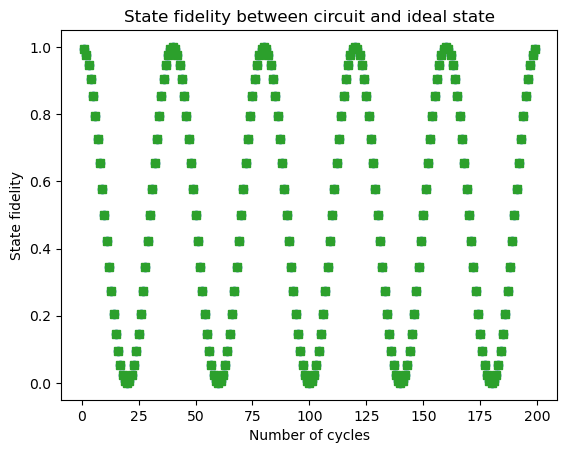

In [49]:
repetitions = np.arange(1, 200)
fidelities1 = []
fidelities2 = []
fidelities3 = []
distances = []
zero_state = Statevector.from_int(0, dims=(2, 2))
for n in repetitions:
    analytic_state = analytic_spillover(α, β, τ, δ, ϕ, γ, n)
    circuit_state = Statevector(full_circuit(ϕ, γ, n, statevector))
    ideal_state = Statevector(ideal_full_circuit(ϕ, n, statevector))
    ideal_reverse_unitary = inverse_unitary(ideal_full_circuit(ϕ, n, statevector))
    fidelities1.append(state_fidelity(circuit_state, ideal_state))
    fidelities2.append(state_fidelity(analytic_state, ideal_state))
    fidelities3.append(state_fidelity(analytic_state.evolve(ideal_reverse_unitary), zero_state))


plt.plot(repetitions, fidelities1, "o", label="Qiskit Statevector")
plt.plot(repetitions, fidelities2, "x", label="Analytic Statevector")
plt.plot(repetitions, fidelities3, "s", label="Analytic Statevector (evolved with inverse ideal unitary)")
plt.xlabel("Number of cycles")
plt.ylabel("State fidelity")
plt.title("State fidelity between circuit and ideal state")

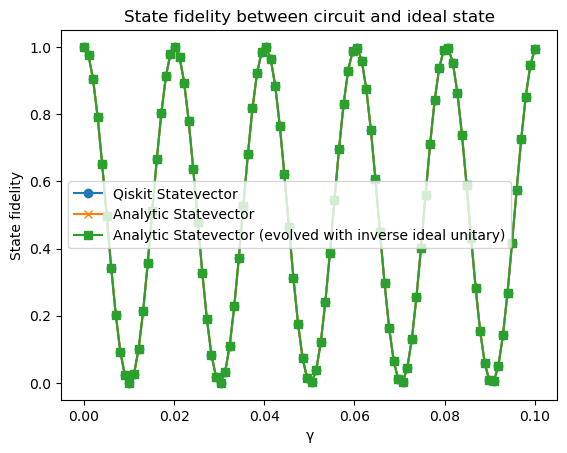

In [52]:
γ_values = np.linspace(0, 0.1, 100)
fidelities1 = []
fidelities2 = []
fidelities3 = []
for γ in γ_values:
    analytic_state = analytic_spillover(α, β, τ, δ, ϕ, γ, n)
    circuit_state = Statevector(full_circuit(ϕ, γ, n, statevector))
    ideal_state = Statevector(ideal_full_circuit(ϕ, n, statevector))
    fidelities1.append(state_fidelity(circuit_state, ideal_state))
    fidelities2.append(state_fidelity(analytic_state, ideal_state))
    fidelities3.append(state_fidelity(analytic_state.evolve(ideal_reverse_unitary), zero_state))

plt.plot(γ_values, fidelities1, "o-", label="Qiskit Statevector")
plt.plot(γ_values, fidelities2, "x-", label="Analytic Statevector")
plt.plot(γ_values, fidelities3, "s-", label="Analytic Statevector (evolved with inverse ideal unitary)")
plt.xlabel("γ")
plt.ylabel("State fidelity")
plt.title("State fidelity between circuit and ideal state")
plt.legend()
